In [1]:
import logging
import os

import matplotlib.pyplot as plt
import pandas as pd
import json

from pathlib import Path

from experiments.tad_help import RTRunner

%load_ext autoreload
%autoreload 2

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "CRITICAL"

logging.basicConfig()
logging.root.setLevel(logging.CRITICAL)
logging.basicConfig(level=logging.CRITICAL)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.CRITICAL))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.CRITICAL)

%aimport setup

from setup import *

# Track Layout
Calculate the layout of the dutch railway system


In [2]:
layout_file =   "../data/prorail/parsed/netherlands-schiphol.json"
layout = Layout(layout_file)

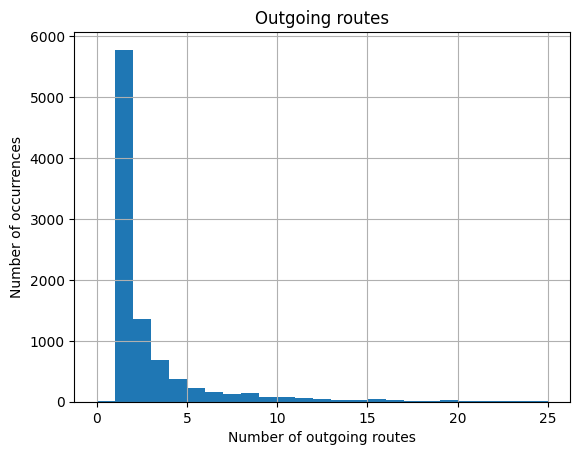

In [3]:
edges_df = pd.DataFrame({"Outgoing routes": [len(n.outgoing) for n in layout.g_block.nodes.values() if len(n.outgoing) <= 25]})
hist = edges_df.hist(bins=25, )
plt.xlabel("Number of outgoing routes")
plt.ylabel("Number of occurrences")
plt.show()

# Experiment Runtime
Take a route of an agent with many stops, and run from start to every stop as an experiment

In [4]:
scenario_files = Path("../data/prorail/scenarios/RT")
save_dir = r"C:\Users\erick\Documents\uni\Thesis\delay-replannning\experiments\results\rt"

In [11]:
i_save_dir = Path(save_dir) / "intermediates"
Path(i_save_dir).mkdir(parents=True, exist_ok=True)

processed = {file.split(".csv")[0] for file in os.listdir(i_save_dir)}

unprocessed_scenarios = set(os.listdir(scenario_files)) - processed
for scenario_file in unprocessed_scenarios:
    try:
        rt_exp = RTRunner(layout, scenario_files / scenario_file, save_dir)
        experiments = rt_exp.run("3500", "o", "RTB", "ASDZ", timeout=1200)
        path_df = rt_exp.get_path_df(experiments)
        path_df.to_csv(i_save_dir / f"{scenario_file}.csv")
    except KeyboardInterrupt:
        raise
    except Exception as e:
        print(e)

..\data\prorail\scenarios\RT\2025-07-21_3.json
..\data\prorail\scenarios\RT\2025-07-18_1.json
..\data\prorail\scenarios\RT\2025-07-03.json
..\data\prorail\scenarios\RT\2025-07-08_4.json
..\data\prorail\scenarios\RT\2025-07-21_1.json
'ICD'
..\data\prorail\scenarios\RT\2025-07-22_1.json


In [12]:
save_path = Path(save_dir)
dfs = []

for file in (save_path / "intermediates").iterdir():
    df = pd.read_csv(file, index_col=0)
    dfs.append(df)

df = pd.concat(dfs, axis=0, keys=list(range(len(dfs))))
df.index = df.index.map(lambda x: (x[0], x[1].split("|")[0]))
df

C:\Users\erick\AppData\Local\Temp\ipykernel_5024\255532974.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs, axis=0, keys=list(range(len(dfs))))


Average path length  Total paths  nodes generated  \
0  route to RTD              3.000000          4.0             15.0   
   route to SDM             10.285714          7.0            162.0   
   route to DT              20.375000          8.0            515.0   
   route to LAA             31.214286         14.0           1026.0   
   route to LEDN            41.916667         12.0           1812.0   
1  route to RTD              3.000000          4.0             19.0   
   route to SDM             10.000000          9.0            181.0   
   route to DT              20.818182         11.0            315.0   
   route to GV              29.800000         10.0            465.0   
   route to LAA             32.833333         12.0            760.0   
   route to LEDN            43.833333         12.0           1991.0   
2  route to RTD              3.000000          4.0             18.0   
   route to SDM             10.000000          7.0            375.0   
   route to DT              21.000000          8.0            196.0   
   route to LAA             32.600000         10.0            606.0   
3  route to RTD              3.000000          4.0             16.0   
   route to SDM             10.400000          5.0            156.0   
   route to DT              21.500000          4.0            289.0   
   route to GV              30.500000          4.0            436.0   
   route to LAA             32.888889          9.0            746.0   
   route to LEDN            46.333333          3.0           1857.0   
   route to SHL             66.000000          4.0           2806.0   
   route to ASDZ            74.233333         30.0           3956.0   
4  route to RTD              3.000000          4.0             15.0   
   route to SDM             10.400000          5.0            166.0   
   route to DT              21.500000          4.0            303.0   
   route to GV              30.400000          5.0            603.0   
   route to LAA             32.333333          9.0            900.0   
   route to LEDN            44.200000          5.0           2545.0   
   route to ASDZ            74.260870         23.0           3537.0   
6  route to RTD              3.000000          6.0             39.0   
   route to SDM             10.000000          6.0            104.0   
   route to DT              21.000000          6.0            150.0   
   route to GV              30.000000         24.0           1776.0   
   route to LAA             32.714286         14.0            806.0   
7  route to RTD              3.000000          6.0           2416.0   
   route to SDM             17.800000         15.0           1062.0   
   route to DT              20.416667         24.0            615.0   
   route to GV              29.416667         24.0            826.0   
   route to LAA             32.416667         24.0           1110.0   
10 route to RTD              3.000000          4.0             10.0   
   route to SDM             10.400000          5.0            140.0   
   route to GV              29.888889          9.0           1243.0   
   route to LAA             32.166667         18.0           2082.0   
   route to LEDN            43.062500         16.0           1933.0   

                  nodes decreased  nodes expanded  Search Time  
0  route to RTD               1.0             5.0        0.499  
   route to SDM              23.0            45.0       13.291  
   route to DT               78.0           234.0       45.788  
   route to LAA             162.0           538.0       73.322  
   route to LEDN            450.0           826.0      168.371  
1  route to RTD               5.0             5.0        0.509  
   route to SDM              28.0            51.0        8.387  
   route to DT               34.0           143.0       11.513  
   route to GV               49.0           250.0       16.475  
   route to LAA             144.0           347.0       66.101  
   route to LEDN            406.0   

,Average path length,Search Time
route to RTD,3.000000,13.192875
route to SDM,11.160714,17.246875
route to DT,20.944264,21.827429
route to GV,30.000926,62.340167
route to LAA,32.395933,81.209625
route to LEDN,43.869167,165.537200
route to SHL,66.000000,215.204000
route to ASDZ,74.247101,170.923500


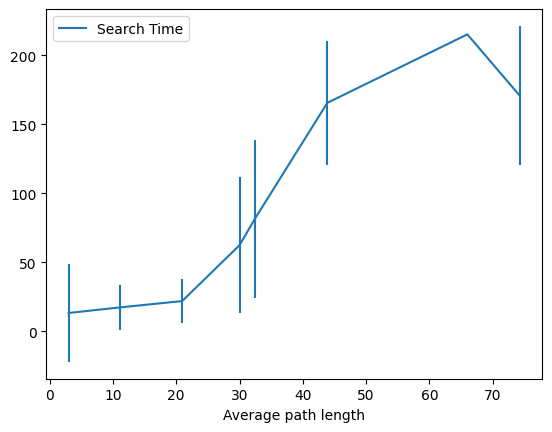

In [13]:
mean_df = df.groupby(level=1).mean().sort_values("Average path length", ascending=True)
mean_df["std"] = df.groupby(level=1).std().sort_values("Average path length", ascending=True)["Search Time"]
mean_df = mean_df[["Average path length", "Search Time", "std"]]
mean_df.set_index("Average path length").plot(yerr="std")
plt.savefig(save_path / "search_time.png")
mean_df[["Average path length", "Search Time"]]